In [126]:
import os
import zipfile
import pandas as pd
import numpy as np
from prettytable import PrettyTable

# We'll also import seaborn, a Python graphing library
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import StratifiedKFold

from IPython.display import display

**Set up where to get data**
==============================

In [4]:
img_dir = '/Users/dmatekenya/world_bank_noaa_images/images_from_noaa'
data_dir = "/Users/dmatekenya/Google Drive/World-Bank/electricity_monitoring/01.data/processed_sms/"

sms1 = pd.read_csv(data_dir + 'sms_observed.csv')
sms2 = pd.read_csv(data_dir + 'sms_rect_hr.csv')

**Generate image metadata**
===============================

In [141]:
def generate_image_metadata(image_dir=None):
    folders = []
    data = []
    img_cnt = 0 

    for entry in os.scandir(img_dir):
        if entry.is_dir():
            folders.append(entry.path)

    for fd in folders:
        for entry in os.scandir(fd):
            if entry.is_file():
                f = entry.name
                print(f)
                if f[-3:] == 'tif':
                    img_cnt += 1
                path = entry.path
                data.append ({'path': path, 'ext': f[-3:],'ts': f[11:19] + ' ' + f[21:27],"te": f[11:19] + ' ' + f[30:36]})

    #create dataframe
    print ('Number of images-%s'%img_cnt)
    df = pd.DataFrame(data)
    
    df['ts'] =  pd.to_datetime(df['ts'], format='%Y%m%d %H%M%S')
    df['te'] =  pd.to_datetime(df['te'], format='%Y%m%d %H%M%S')
    df['hr'] =  df.apply (lambda x: x['ts'].hour, axis = 1)
    
    return df

**Basic image metadata for presentation**
---------------------------------------------

In [4]:
def print_image_hrs_meta(df=None, target_var='hr'):
    x = PrettyTable(field_names=['Acquisition hour', 'Proportion (%)'])
    counts = df[target_var].value_counts(normalize=True)
    for idx in counts.index:
        x.add_row([idx, round(counts[idx] * 100, 2)])
    print('Image acquisition time-summary')
    print('===============================')
    print(x)

**EXTRACT ONLY NIGHT OUTAGES!!!**
==================================
From sm2_rect_hr.csv, keep only required events
1. Limit hours to match those in images
2. Summarise events by PSU (For this analysis, 
I only keep hours which have same event in both boxes)

In [6]:
def summarise_events_by_psu(df_psu):
    """
    Very strict: Take only hours where boxes have same events and discard the rest
    """
    hrs = df_psu.str_datetime_sent_hr.unique()
    keep = []
    
    for hr in hrs:
        df_hr = df_psu[df_psu.str_datetime_sent_hr==hr]
        events = df_hr.power_state.unique()
    
        if len(events) > 1:
            # print('Different events, drop this hours')
            continue
        elif len(events)==1:
            keep.append(hr)
    
    # 
    df_psu2 = df_psu[df_psu['str_datetime_sent_hr'].isin(keep)]
    
    df_psu3 = df_psu2.groupby(['psu', 'lon', 'lat', 'str_datetime_sent_hr'])['power_state'].max()
    
    return df_psu3.reset_index()

In [7]:
def generate_event_data_by_psu(df):

    for i, psu in enumerate(list(df.psu.unique())):
        df_psu = summarise_events_by_psu(df[df.psu==psu])
        
        if i == 0:
            all_df = df_psu
        elif i > 0:
            all_df = all_df.append(df_psu)
            
    return all_df  

In [11]:
def extract_data_for_image_analysis(sms2, hrs=[18, 19, 20, 21, 22]):
    
    # preliminary processing
    sms2_ = sms2[sms2.power_state != -1]
    reqcols = ['box_id', 'region', 'district', 'urban_rural', 'psu', 'lon', 'lat',
       'str_datetime_sent','str_datetime_sent_hr', 'day_sent', 'hour_sent', 'month_sent',
       'power_state', 'data_source']
    sms2_ = sms2_[reqcols]
    
    sms2_night = sms2_[sms2['hour_sent'].isin([18, 19, 20, 21, 22])]
    
    # generate event data by psu
    df2 = generate_event_data_by_psu(sms2_night)
    
    return df2

In [50]:
def join_image_box_data(df_box=None,df_image=None):
    # covert datetime for images to hour based on starttime
    df_image['image_date'] = df_image['ts'].values.astype('<M8[h]')
    
    df_image = df_image[['image_date', 'path']]
    
    # Ensure str_datetime_sent_hr is in datetime format
    df_box['str_datetime_sent_hr'] =  pd.to_datetime(df_box['str_datetime_sent_hr'])
    
    #merge
    
    df = df_box.merge(right=df_image, how='inner', right_on='image_date', 
                      left_on='str_datetime_sent_hr')
    
    return df

In [49]:
df = extract_data_for_image_analysis(sms2, hrs=[18, 19, 20, 21, 22])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [15]:
df.to_csv(data_dir + 'psu_power_state.csv', index=False)

In [48]:
def save_location_data(df):
    """
    Save lat_lon in file
    """

    location_file = df.groupby(['psu', 'lon', 'lat']).agg('count')
    xy = location_file.reset_index()
    xy = xy[['psu', 'lon', 'lat']]
    # Remove PSU 21 because of bad coordinates
    xy = xy [xy.psu != 21]
    xy.to_csv(data_dir + 'lat_lon.csv', index=False)

In [54]:
# save events which with corresponding image
df_image_box.rename(columns={'path':'image_path'})
df_image_box.to_csv(data_dir + 'box_events_vs_image.csv', index=False)

**Analyse the pixel values**
=============================
After extracting pixel values at the locaitons, lets check out how it looks.


In [155]:
pix = pd.read_csv(data_dir + 'box_events_vs_image3.csv')

In [156]:
pix.head()

,psu,lon,lat,str_datetime_sent_hr,power_state,image_date,path,radiance
0,35,69.075835,38.563905,2016-11-22 22:00:00,0,2016-11-22 22:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,1.555751
1,113,69.945693,40.432452,2016-11-22 22:00:00,1,2016-11-22 22:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,1.286921
2,140,67.627770,39.499137,2016-11-22 22:00:00,0,2016-11-22 22:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,1.803644
3,97,69.756089,38.355409,2016-11-22 22:00:00,0,2016-11-22 22:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,0.761194
4,47,70.090710,38.995396,2016-11-22 22:00:00,0,2016-11-22 22:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,0.996926


In [61]:
pix['log_radiance'] = pix.radiance.map(np.log)

In [81]:
# Let's look at the density of the age of happy/unhappy customers for saldo_var30
def plot_radiance_by_power_status(df_pix, target_var, filename, xlabel):
    # df_pix = df_pix[df_pix.radiance < 40]
    sns.set_palette("husl", 2)
    sns.set_style('darkgrid', {'legend.frameon':True})
    g = sns.FacetGrid(df_pix, hue="power_state", size=8) \
           .map(sns.kdeplot, target_var) \
           .add_legend()
    
    g.set_xlabels(xlabel)
    g.set_ylabels('Proportion')
    
    print(dir(g))
    g.fig.savefig(filename)
    plt.show()

** How good can pixel values predict power_status**
===================================================


In [50]:
pix.power_state.value_counts(normalize=True)

1    0.899346
0    0.100654
Name: power_state, dtype: float64

In [51]:
pix.shape

(25672, 8)

In [83]:
pix.head()

,psu,lon,lat,str_datetime_sent_hr,power_state,image_date,path,radiance,log_radiance
0,35,69.075835,38.563905,2016-11-22 22:00:00,0,2016-11-22 22:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,1.555751,0.441959
1,113,69.945693,40.432452,2016-11-22 22:00:00,1,2016-11-22 22:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,1.286921,0.252253
2,140,67.627770,39.499137,2016-11-22 22:00:00,0,2016-11-22 22:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,1.803644,0.589809
3,97,69.756089,38.355409,2016-11-22 22:00:00,0,2016-11-22 22:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,0.761194,-0.272867
4,47,70.090710,38.995396,2016-11-22 22:00:00,0,2016-11-22 22:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,0.996926,-0.003079


In [95]:
px = pix.dropna(subset=['log_radiance'])

In [93]:
n = pix.loc[pix.log_radiance.isnull()]
n2 = pix.loc[pix.radiance.isnull()]

In [98]:
nn = px.loc[pix.log_radiance.isnull()]

In [99]:
nn.shape

(0, 9)

In [100]:
pix.shape

(25672, 9)

In [115]:
dark_nights = pix_counts.reset_index()

In [120]:
dark_nights.head()

,str_datetime_sent_hr,path,power_state
0,2016-10-24 21:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,3
1,2016-10-25 21:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,5
2,2016-10-26 20:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,6
3,2016-10-27 20:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,9
4,2016-10-27 22:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,2


In [123]:
dark_nights2 = dark_nights.sort_values(by='power_state',ascending=False)

In [119]:
dark_nights.loc[0].path

'/Users/dmatekenya/world_bank_noaa_images/images_from_noaa/SVDNB_npp_d201610/SVDNB_npp_d20161024_t2123409_e2129213_b25871_c20161025032921541333_noaa_ops_tjk.rade9.tif'

In [129]:
for index, row in dark_nights2.iterrows():
    #display(print(row['path'], 'outages-->', row['power_state']))
    
    if row['power_state'] < 10:
        print(row['path'])
        

/Users/dmatekenya/world_bank_noaa_images/images_from_noaa/SVDNB_npp_d201611/SVDNB_npp_d20161111_t2047294_e2053098_b26126_c20161112025310158569_noaa_ops_tjk.rade9.tif
/Users/dmatekenya/world_bank_noaa_images/images_from_noaa/SVDNB_npp_d201610/SVDNB_npp_d20161027_t2025286_e2036506_b25913_c20161028023651896306_noaa_ops_tjk.rade9.tif
/Users/dmatekenya/world_bank_noaa_images/images_from_noaa/SVDNB_npp_d201611/SVDNB_npp_d20161103_t1954013_e2005233_b26012_c20161104020523675834_noaa_ops_tjk.rade9.tif
/Users/dmatekenya/world_bank_noaa_images/images_from_noaa/SVDNB_npp_d201611/SVDNB_npp_d20161107_t2203101_e2208505_b26070_c20161108040851874720_noaa_ops_tjk.rade9.tif
/Users/dmatekenya/world_bank_noaa_images/images_from_noaa/SVDNB_npp_d201611/SVDNB_npp_d20161106_t2220403_e2226207_b26056_c20161107042621471215_noaa_ops_tjk.rade9.tif
/Users/dmatekenya/world_bank_noaa_images/images_from_noaa/SVDNB_npp_d201611/SVDNB_npp_d20161103_t2136269_e2142073_b26013_c20161104034207792767_noaa_ops_tjk.rade9.tif
/Use

In [139]:
from shutil import copyfile
for index, row in dark_nights2.iterrows():
    #display(print(row['path'], 'outages-->', row['power_state']))
    
    image_path = row['path']
    img_name = str(row['power_state']) + '_' + image_path.split('/')[-1]
    copyfile(image_path, img_dir + '/selected_imgs/' + img_name)

In [131]:
x = '/Users/dmatekenya/world_bank_noaa_images/images_from_noaa/SVDNB_npp_d201611/SVDNB_npp_d20161111_t2047294_e2053098_b26126_c20161112025310158569_noaa_ops_tjk.rade9.tif'


In [150]:
dark_nights2.sort_values(by=['power_state','str_datetime_sent_hr'], ascending=False)

,str_datetime_sent_hr,path,power_state
166,2017-02-16 22:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,113
165,2017-02-16 20:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,112
94,2016-12-30 20:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,112
233,2017-04-01 21:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,111
144,2017-02-01 21:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,111
138,2017-01-28 21:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,111
122,2017-01-18 21:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,111
93,2016-12-29 20:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,111
89,2016-12-26 19:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,111
240,2017-04-06 21:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,110


In [151]:
dark_nights2[dark_nights2.power_state==104]

,str_datetime_sent_hr,path,power_state
119,2017-01-16 20:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,104
180,2017-02-26 20:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,104
167,2017-02-17 20:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,104
153,2017-02-07 21:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,104
112,2017-01-11 20:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,104
157,2017-02-10 22:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,104
120,2017-01-16 21:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,104
152,2017-02-07 19:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,104
133,2017-01-25 22:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,104
249,2017-04-12 21:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,104


In [152]:
df_img.head()

,psu,lon,lat,str_datetime_sent_hr,power_state,image_date,path,radiance
23070,35,69.075835,38.563905,2017-04-24 21:00:00,1,2017-04-24 21:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,2.0
23071,113,69.945693,40.432452,2017-04-24 21:00:00,1,2017-04-24 21:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,0.0
23072,22,68.720459,38.495431,2017-04-24 21:00:00,1,2017-04-24 21:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,7.0
23073,97,69.756089,38.355409,2017-04-24 21:00:00,1,2017-04-24 21:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,0.0
23074,47,70.090710,38.995396,2017-04-24 21:00:00,1,2017-04-24 21:00:00,/Users/dmatekenya/world_bank_noaa_images/image...,0.0


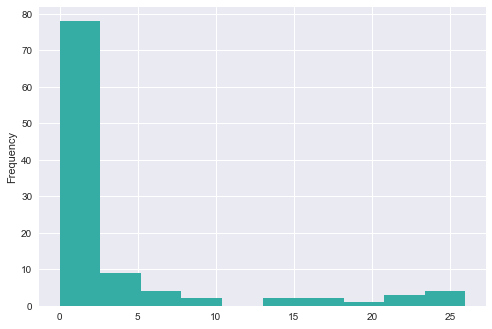

In [154]:
df_img.radiance.plot(kind='hist')
plt.show()